#  Northwind BI Dashboard



In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
import os
import itertools

# 1. Setup Paths
CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))
if 'notebooks' in CURRENT_DIR: 
    BASE_DIR = os.path.dirname(CURRENT_DIR)
else:
    BASE_DIR = os.getcwd()
WAREHOUSE_DIR = os.path.join(BASE_DIR, 'data', 'warehouse')

print(f"Loading data from: {WAREHOUSE_DIR}")

# 2. Load Data
fact_sales = pd.read_parquet(os.path.join(WAREHOUSE_DIR, 'FactSales.parquet'))
dim_date = pd.read_parquet(os.path.join(WAREHOUSE_DIR, 'DimDate.parquet'))
dim_emp = pd.read_parquet(os.path.join(WAREHOUSE_DIR, 'DimEmployee.parquet'))
#dim_prod = pd.read_parquet(os.path.join(WAREHOUSE_DIR, 'DimProduct.parquet'))
dim_client = pd.read_parquet(os.path.join(WAREHOUSE_DIR, 'DimClient.parquet'))

# Fix column names if needed
if 'sk_date' not in dim_date.columns and 'date_key' in dim_date.columns:
    dim_date = dim_date.rename(columns={'date_key': 'sk_date'})

dim_emp = dim_emp.rename(columns={'city': 'emp_city', 'country': 'emp_country', 'region': 'emp_region', 'title': 'emp_title'})
dim_client = dim_client.rename(columns={'region': 'client_region'})

# 3. Merge
df = pd.merge(fact_sales, dim_date, on='sk_date', how='left')
df = pd.merge(df, dim_emp, on='sk_employee', how='left')
#df = pd.merge(df, dim_prod, on='sk_product', how='left')
df = pd.merge(df, dim_client, on='sk_client', how='left')

# 4. Clean & Calculate
#df['company_name'] = df['company_name'].fillna('Unknown Client')
df['Employee_name'] = df['Employee_name'].fillna('Unknown Employee')
df['date_obj'] = pd.to_datetime(df['full_date'])
df['year_month'] = df['date_obj'].dt.strftime('%Y-%m')
# Drop Unknown clients for clean visuals

# 5. Prepare Continuous Year Options
min_year = int(df['year'].min())
max_year = int(df['year'].max())
available_years = list(range(min_year, max_year + 1))
year_options = ['All Years'] + [str(y) for y in available_years]
print(f"Dashboard Ready.")
print(f"Years Available: {year_options}")

Loading data from: /mnt/d/ayoub/3rd year/S5-20250724T141727Z-1-001/S5/bii_tae_hannane/2/data/warehouse
Dashboard Ready.
Years Available: ['All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006']


In [2]:
# KPIs: REVENUE, ORDERS & DELIVERY ---
kpi_dropdown = widgets.Dropdown(options=year_options, value='All Years', description='Date:')
kpi_output = widgets.Output()

def update_kpi(change):
    selected_year = change['new']
    with kpi_output:
        clear_output(wait=True)
        if selected_year == 'All Years': data = df.copy()
        else: data = df[df['year'] == int(selected_year)]
            
        if data.empty:
            display(Markdown("### No data for this period"))
            return

        # 1. Financials
        rev = data['total_amount'].sum()
        
        # 2. Orders & Delivery (Count unique orders)
        uniq_orders = data.drop_duplicates(subset=['bk_order_id'])
        total_orders = len(uniq_orders)
        
        shipped = len(uniq_orders[uniq_orders['delivery_status'] == 'Livrée'])
        pending = len(uniq_orders[uniq_orders['delivery_status'] == 'Non Livrée'])
        
        shipped_pct = (shipped / total_orders * 100) if total_orders > 0 else 0
        pending_pct = (pending / total_orders * 100) if total_orders > 0 else 0

        # 3. Create Indicators
        fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'indicator'}]*4])

        fig.add_trace(go.Indicator(
            mode="number", value=rev, title={"text": "Total Revenue"},
            number={'prefix': "$", "font": {"size": 40, "color": "#636EFA"}}
        ), row=1, col=1)

        fig.add_trace(go.Indicator(
            mode="number", value=total_orders, title={"text": "Total Orders"},
            number={"font": {"size": 40}}
        ), row=1, col=2)

        fig.add_trace(go.Indicator(
            mode="number", value=shipped, title={"text": f"Delivered ({shipped_pct:.1f}%)"},
            number={"font": {"size": 40, "color": "#00CC96"}}
        ), row=1, col=3)

        fig.add_trace(go.Indicator(
            mode="number", value=pending, title={"text": f"Not Delivered ({pending_pct:.1f}%)"},
            number={"font": {"size": 40, "color": "#EF553B"}}
        ), row=1, col=4)

        fig.update_layout(height=100, margin=dict(l=20, r=20, t=50, b=20))
        fig.show()

kpi_dropdown.observe(update_kpi, names='value')
display(Markdown("### Executive Summary"), kpi_dropdown, kpi_output)
update_kpi({'new': 'All Years'})

### Executive Summary

Dropdown(description='Date:', options=('All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2…

Output()

In [3]:
#  EMPLOYEE LOGISTICS PERFORMANCE
emp_dropdown = widgets.Dropdown(options=year_options, value='All Years', description='Date:')
emp_output = widgets.Output()

def update_employee_delivery(change):
    selected_year = change['new']
    with emp_output:
        clear_output(wait=True)
        
        if selected_year == 'All Years': data = df.copy()
        else: data = df[df['year'] == int(selected_year)]
            
        # Count unique orders
        emp_stats = data.drop_duplicates(subset=['bk_order_id']).groupby(['Employee_name', 'delivery_status']).size().reset_index(name='count')
        emp_stats = emp_stats.sort_values(by='count')

        fig = px.bar(
            emp_stats, x='count', y='Employee_name', color='delivery_status',
            title=f"Employee Delivery Performance ({selected_year})",
            barmode='stack',
            orientation='h',
            color_discrete_map={'Livrée': '#00CC96', 'Non Livrée': '#EF553B'}
        )
        fig.update_layout(height=500)
        fig.show()

emp_dropdown.observe(update_employee_delivery, names='value')
display(Markdown("###  Employee Logistics Performance"), emp_dropdown, emp_output)
update_employee_delivery({'new': 'All Years'})

###  Employee Logistics Performance

Dropdown(description='Date:', options=('All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2…

Output()

In [4]:
# DELIVERY STATUS OVER TIME
del_date_dropdown = widgets.Dropdown(options=year_options, value='All Years', description='Date:')
del_date_output = widgets.Output()

def update_del_date(change):
    selected_year = change['new']
    with del_date_output:
        clear_output(wait=True)
        
        # 1. Determine Date Range
        if selected_year == 'All Years':
            start_date = df['date_obj'].min()
            end_date = df['date_obj'].max()
            freq = 'MS' # Month Start
            format_str = '%Y-%m'
        else:
            start_date = pd.Timestamp(f"{selected_year}-01-01")
            end_date = pd.Timestamp(f"{selected_year}-12-31")
            freq = 'MS'
            format_str = '%B' # Month Name

        # 2. Generate FULL Timeline (The "Densification")
        full_timeline = pd.date_range(start=start_date, end=end_date, freq=freq)
        timeline_df = pd.DataFrame({'date_obj': full_timeline})
        timeline_df['time_key'] = timeline_df['date_obj'].dt.strftime(format_str)

        # 3. Prepare Actual Data
        if selected_year == 'All Years':
            data = df.copy()
            data['time_key'] = data['year_month']
        else:
            data = df[df['year'] == int(selected_year)].copy()
            data['time_key'] = data['date_obj'].dt.strftime('%B')

        # Count data
        actual_counts = data.drop_duplicates(subset=['bk_order_id']).groupby(['time_key', 'delivery_status']).size().reset_index(name='count')

        # 4. Merge Full Timeline with Actual Data (Left Join)
        # This forces the empty months to appear with NaN (which we fill with 0)
        merged = pd.merge(timeline_df, actual_counts, on='time_key', how='left')
        merged['count'] = merged['count'].fillna(0)
        merged['delivery_status'] = merged['delivery_status'].fillna('Non Livrée') # Default for empty bars

        # 5. Plot
        fig = px.bar(
            merged, x='time_key', y='count', color='delivery_status',
            title=f"Delivery Status Timeline ({selected_year})",
            barmode='stack',
            color_discrete_map={'Livrée': '#00CC96', 'Non Livrée': '#EF553B'}
        )
        # Update X-axis to show all ticks
        fig.update_xaxes(type='category')
        fig.show()

del_date_dropdown.observe(update_del_date, names='value')
display(Markdown("### Delivery Status by Date"), del_date_dropdown, del_date_output)
update_del_date({'new': 'All Years'})

### Delivery Status by Date

Dropdown(description='Date:', options=('All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2…

Output()

In [5]:
#  CLIENT DELIVERY STATUS
client_dropdown = widgets.Dropdown(options=year_options, value='All Years', description='Date:')
client_output = widgets.Output()

def update_client_delivery(change):
    selected_year = change['new']
    with client_output:
        clear_output(wait=True)
        
        # 1. Filter Data
        if selected_year == 'All Years': 
            data = df.copy()
        else: 
            # Ensure safe integer conversion
            data = df[df['year'] == int(selected_year)]
            
        # 2. Check if data exists
        if data.empty:
            print(f" No sales found for {selected_year}.")
            return

        # 3. Aggregate Data
        # Count unique orders per client
        client_stats = data.drop_duplicates(subset=['bk_order_id']).groupby(['company_name', 'delivery_status']).size().reset_index(name='count')
        
        if client_stats.empty:
            print(f"⚠ Data found, but no client stats generated.")
            return

        # Sort so the biggest bars are at the bottom
        client_stats = client_stats.sort_values(by='count')

        # 4. Plot
        fig = px.bar(
            client_stats, x='count', y='company_name', color='delivery_status',
            title=f"Delivery Status By Cient({selected_year})",
            barmode='stack',
            orientation='h',
            color_discrete_map={'Livrée': '#00CC96', 'Non Livrée': '#EF553B'},
            labels={'company_name': 'Client', 'count': 'Number of Orders'}
        )
        
        # Height 1200px to fit all clients
        fig.update_layout(height=1200, margin=dict(l=0, r=0, t=40, b=0)) 
        fig.show()

client_dropdown.observe(update_client_delivery, names='value')
display(Markdown("### Client Delivery Analysis"), client_dropdown, client_output)

# Trigger initial load
update_client_delivery({'new': 'All Years'})

### Client Delivery Analysis

Dropdown(description='Date:', options=('All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2…

Output()

In [6]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
import itertools

#Focus on 3 Dimensions: Employee, Client, Date
if 'Employee_name' not in df.columns:
    df['Employee_name'] = df['first_name'].astype(str) + " " + df['last_name'].astype(str)

# Clean nulls for display
df['company_name'] = df['company_name'].fillna('Unknown Client')
df['Employee_name'] = df['Employee_name'].fillna('Unknown Employee')
df['year_month'] = df['date_obj'].dt.strftime('%Y-%m')

# INTERACTIVE 3D GRAPH 
olap_dropdown = widgets.Dropdown(options=year_options, value='All Years', description='Date:')
olap_output = widgets.Output()

def update_olap(change):
    selected_year = change['new']
    with olap_output:
        clear_output(wait=True)
        
        #  AXIS LOGIC (Time Dimension)
        if selected_year == 'All Years':
            data = df.copy()
            time_col = 'year'
            # Force timeline: 1996 to 2006
            min_y, max_y = int(data['year'].min()), int(data['year'].max())
            full_timeline = [str(y) for y in range(min_y, max_y + 1)]
            xlabel = 'Year'
        else:
            data = df[df['year'] == int(selected_year)].copy()
            time_col = 'year_month'
            # Force timeline: Jan to Dec
            full_timeline = [f"{selected_year}-{m:02d}" for m in range(1, 13)]
            xlabel = 'Month'

        if data.empty and selected_year == 'All Years':
            display(Markdown("###  No data available."))
            return

        # We Group ONLY by: Time, Client, Employee.
        
        if not data.empty:
            # Filter Top 10 Clients to keep the 3D cube readable
            top_clients = data.groupby('company_name')['total_amount'].sum().nlargest(10).index.tolist()
            employees = data['Employee_name'].unique().tolist()
        else:
            top_clients = []
            employees = []
        
        # 1. Create Cartesian Grid 
        grid = pd.DataFrame(list(itertools.product(full_timeline, top_clients, employees)), 
                            columns=[time_col, 'company_name', 'Employee_name'])
        
        # 2. Clean Time Column for Merging
        data[time_col] = data[time_col].astype(str).str.replace(r'\.0', '', regex=True)

        # 3. Calculate Facts (Revenue)
        actuals = data.groupby([time_col, 'company_name', 'Employee_name'])['total_amount'].sum().reset_index()
        
        # 4. Merge Grid (Densification)
        df_dense = pd.merge(grid, actuals, on=[time_col, 'company_name', 'Employee_name'], how='left')
        df_dense['total_amount'] = df_dense['total_amount'].fillna(0)

        # --- C. SPLIT LAYERS (For Visualization) ---
        df_zeros = df_dense[df_dense['total_amount'] == 0]
        df_sales = df_dense[df_dense['total_amount'] > 0]  

        # PLOT 
        fig = px.scatter_3d(
            df_sales, 
            x=time_col, 
            y='company_name', 
            z='Employee_name',
            size='total_amount', 
            color='total_amount', 
            opacity=0.9,
            color_continuous_scale='Portland',
            title=f"3D OLAP:{xlabel} x Client x Employee",
            labels={'total_amount': 'Revenue', time_col: xlabel, 'company_name': 'Client', 'Employee_name': 'Employee'}
        )

        fig.add_trace(go.Scatter3d(
            x=df_zeros[time_col],
            y=df_zeros['company_name'],
            z=df_zeros['Employee_name'],
            mode='markers',
            marker=dict(size=4, color='lightgrey', opacity=0.3, symbol='circle'),
            name=' No Orders (Gap)'
        ))
        
        # FORCE AXIS SORTING 
        fig.update_layout(
            height=700, 
            margin=dict(l=0, r=0, b=0, t=40),
            showlegend=True,
            legend=dict(x=0, y=1, bgcolor="rgba(255,255,255,0.8)", borderwidth=1),
            scene=dict(
                xaxis=dict(
                    title=xlabel, 
                    type='category', 
                    categoryorder='array', 
                    categoryarray=full_timeline, #  1996, 1997, 1998...
                    tickmode='linear', 
                    dtick=1
                ),
                yaxis=dict(title='Client'),
                zaxis=dict(title='Employee')
            )
        )
        fig.show()

olap_dropdown.observe(update_olap, names='value')
display(Markdown("###  3D OLAP Analysis ( Time, Client, Employee)"), olap_dropdown, olap_output)
update_olap({'new': 'All Years'})

###  3D OLAP Analysis ( Time, Client, Employee)

Dropdown(description='Date:', options=('All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2…

Output()

In [7]:
#  REGIONAL & EMPLOYEE DELIVERY
region_dropdown = widgets.Dropdown(options=year_options, value='All Years', description='Date:')
region_output = widgets.Output()

def update_region(change):
    selected_year = change['new']
    with region_output:
        clear_output(wait=True)
        
        if selected_year == 'All Years': data = df.copy()
        else: data = df[df['year'] == int(selected_year)]
            
        if 'sales_region' not in data.columns: data['sales_region'] = 'Unknown'
        
        sunburst_df = data.drop_duplicates(subset=['bk_order_id']).groupby(
            ['sales_region', 'Employee_name', 'delivery_status']
        ).size().reset_index(name='count')

        fig = px.sunburst(
            sunburst_df, path=['sales_region', 'Employee_name', 'delivery_status'], values='count',
            color='delivery_status',
            color_discrete_map={'Livrée': '#00CC96', 'Non Livrée': '#EF553B', '(?)': '#ddd'},
            title=f"Delivery Hierarchy ({selected_year})"
        )
        fig.update_layout(height=600)
        fig.show()

region_dropdown.observe(update_region, names='value')
display(Markdown("###  Regional & Employee Delivery Analysis"), region_dropdown, region_output)
update_region({'new': 'All Years'})

###  Regional & Employee Delivery Analysis

Dropdown(description='Date:', options=('All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2…

Output()

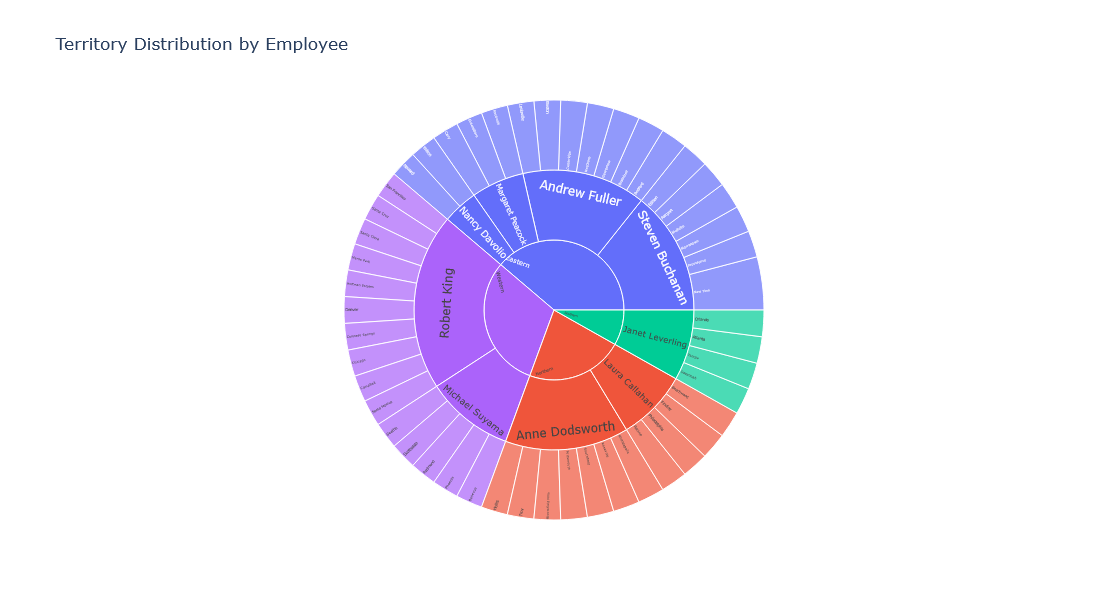

In [8]:
# DETAILED TERRITORY ASSIGNMENT (SPLIT ROWS) 
import pandas as pd
import plotly.express as px
from IPython.display import display, Markdown
import os

#  Load the Raw Territory Tables (We need the raw connections to split the rows)
CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))
if 'notebooks' in CURRENT_DIR: BASE_DIR = os.path.dirname(CURRENT_DIR)
else: BASE_DIR = os.getcwd()
RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')

try:
    # Load raw CSVs
    raw_emp_terr = pd.read_csv(os.path.join(RAW_DIR, 'sql_employeeterritories.csv'))
    raw_terr = pd.read_csv(os.path.join(RAW_DIR, 'sql_territories.csv'))
    raw_region = pd.read_csv(os.path.join(RAW_DIR, 'sql_region.csv'))

    # Normalize column names
    raw_emp_terr.columns = [c.lower().strip() for c in raw_emp_terr.columns]
    raw_terr.columns = [c.lower().strip() for c in raw_terr.columns]
    raw_region.columns = [c.lower().strip() for c in raw_region.columns]

    # Join Employee Dimension to the Bridge Table
    emp_geo = pd.merge(dim_emp, raw_emp_terr, left_on='bk_employee_id', right_on='employeeid', how='inner')
    
    # Join with Territory Names
    emp_geo = pd.merge(emp_geo, raw_terr, on='territoryid', how='inner')
    
    # Join with Region Names
    emp_geo = pd.merge(emp_geo, raw_region, on='regionid', how='inner')

    # Select only what we need to show the "Split"
    split_view = emp_geo[['Employee_name', 'emp_title', 'regiondescription', 'territorydescription']].copy()
    split_view.columns = ['Employee Name', 'Title', 'Region', 'Territory']
    
    # Sort for clarity
    split_view = split_view.sort_values(by=['Employee Name', 'Region', 'Territory'])


    # This chart proves you have the hierarchy data
    fig = px.sunburst(
        split_view, 
        path=['Region', 'Employee Name', 'Territory'],
        title="Territory Distribution by Employee",
        color='Region'
    )
    fig.update_layout(height=600)
    fig.show()

except Exception as e:
    print(f"Could not load territory details: {e}")
    print("Ensure you extracted 'sql_employeeterritories.csv' and 'sql_territories.csv'.")

In [9]:
# INTERACTIVE SALES TREND 
trend_dropdown = widgets.Dropdown(options=year_options, value='All Years', description=' Date:')
trend_output = widgets.Output()

def update_trend(change):
    selected_year = change['new']
    with trend_output:
        clear_output(wait=True)
        
        if selected_year == 'All Years':
            data = df.copy()
            # FIX: When viewing all time, group by YEAR, not Month
            x_col = 'year' 
            title_text = "Yearly Revenue Evolution"
        else:
            data = df[df['year'] == int(selected_year)].copy()
            x_col = 'month_name'
            title_text = f"Monthly Revenue Trend ({selected_year})"
            
        # Aggregate
        trend_df = data.groupby(x_col)['total_amount'].sum().reset_index()
        
        # Sort Logic
        if selected_year != 'All Years':
            # Sort Months
            months = ['January', 'February', 'March', 'April', 'May', 'June', 
                      'July', 'August', 'September', 'October', 'November', 'December']
            trend_df['month_name'] = pd.Categorical(trend_df['month_name'], categories=months, ordered=True)
            trend_df = trend_df.sort_values('month_name')
        else:
            # Sort Years
            trend_df = trend_df.sort_values('year')

        # Plot
        fig = px.line(
            trend_df, 
            x=x_col, 
            y='total_amount', 
            markers=True, 
            title=title_text,
            labels={'total_amount': 'Revenue', 'year': 'Year', 'month_name': 'Month'}
        )
        fig.update_traces(line_color='#636EFA')
        fig.update_yaxes(rangemode="tozero")
        fig.show()

trend_dropdown.observe(update_trend, names='value')
display(Markdown("###  Revenue Evolution"), trend_dropdown, trend_output)
update_trend({'new': 'All Years'})

###  Revenue Evolution

Dropdown(description=' Date:', options=('All Years', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '…

Output()